# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [13]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [14]:
import PIL
print(PIL.__version__)

10.2.0


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [15]:
import pickle
from pathlib import Path
from multiprocessing.pool import ThreadPool

import numpy as np
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [16]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 256
DATA_DIR = Path('./simsons')
# работаем на видеокарте
DEVICE = torch.device("cuda")
# DEVICE = torch.device("cpu")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [17]:
from typing import Literal


class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    LABEL_DIR = DATA_DIR.joinpath('label_encoder.pkl')

    def __init__(self, files: list[Path], mode: Literal['train', 'val', 'test']):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open(self.LABEL_DIR, 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        
        if mode == 'train':
            self.transform = v2.Compose([
                v2.PILToTensor(),
                v2.RandomAffine((-20, 20), (0.05, 0.05), (0.95, 1.0)),
                v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),          
                v2.RandomHorizontalFlip(0.5),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = v2.Compose([
                v2.PILToTensor(),
                v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),          
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [18]:
def imshow(inp: torch.Tensor, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [19]:
TRAIN_DIR = DATA_DIR.joinpath('train/')
TEST_DIR = DATA_DIR.joinpath('testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [20]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files,
    test_size=0.25,
    stratify=train_val_labels
)

Давайте посмотрим на наших героев внутри датасета.

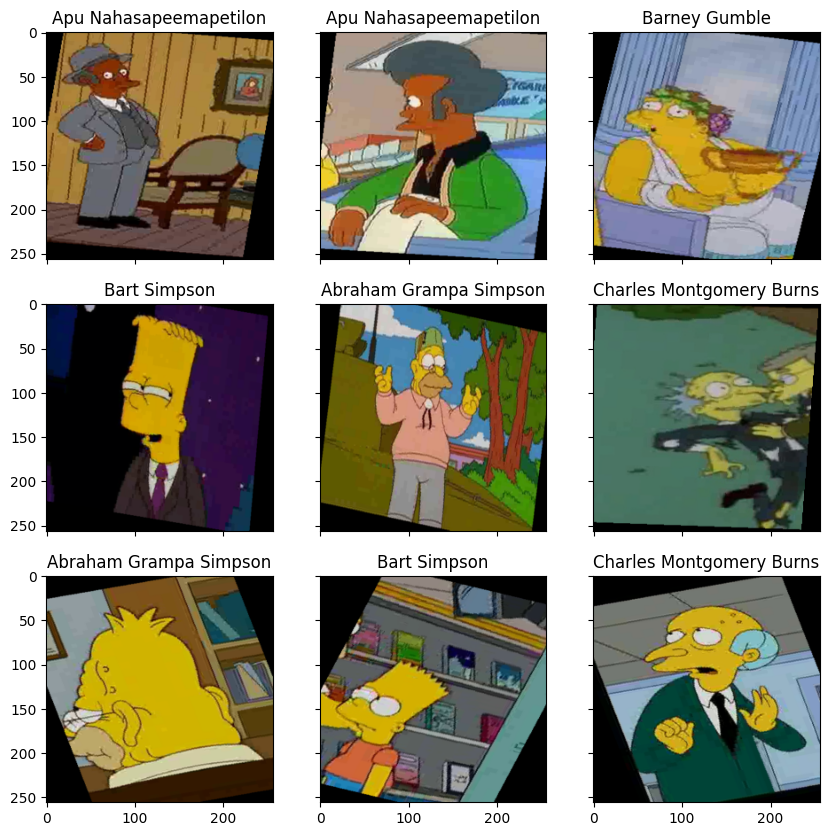

In [21]:
val_dataset = SimpsonsDataset(val_files, mode='train')

fig, ax = plt.subplots(
    nrows=3, ncols=3,
    figsize=(10, 10),
    sharey=True, sharex=True
)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    FIO_lowcase = val_dataset.label_encoder.inverse_transform([label])[0].split('_')
    img_label = " ".join(map(lambda x: x.capitalize(), FIO_lowcase))
    
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [22]:
from typing import Literal

from torch import nn


class ConvLayer(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        pool: Literal["max", "adaptive_avg"] = "max",
    ):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)
        if pool == "max":
            self.pool = nn.MaxPool2d(kernel_size=2)
        elif pool == "adaptive_avg":
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
        else:
            raise Exception("Pool type is undefined")

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out + x)
        out = self.batchnorm3(out)
        out = self.act(out)
        out = self.pool(out)
        return out


class MediumCnn(nn.Module):

    def __init__(self, n_classes: int):
        super().__init__()
        self.conv1 = ConvLayer(3, 16)
        self.conv2 = ConvLayer(16, 32)
        self.conv3 = ConvLayer(32, 64)
        self.conv4 = ConvLayer(64, 128)
        self.conv5 = ConvLayer(128, 256)
        self.conv6 = ConvLayer(256, 512)
        self.conv7 = ConvLayer(512, 512, pool="adaprive_avg")

        self.flatten = nn.Flatten()
        self.act = nn.Tanh()

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 1 * 1, 256),
            nn.BatchNorm1d(256),
            self.act,
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            self.act,
        )
        self.out = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits


---
**Мысли автора**

Изначально я пошел по пути Transfer Learning (ResNet18), достиг 0.99 и не успокоился. Поэтому в Кагле можно найти 2 решения. Здесь я решил сделать свою архитектуру 

Обучение происходило локально в файле (тк эти ноутбуки плохо поддерживают многопроцессорность. Да и в целом эти ноутбуки неоптимизированные), поэтому логов нет.

Дальше я просто подгружу сюда уже свою обученную модель

---

In [32]:
def predict(model: nn.Module, test_loader: DataLoader):
    """Ответ модели."""
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [33]:
n_classes = len(np.unique(train_val_labels))
model = MediumCnn(n_classes)
print(f"we will classify :{n_classes}")
print(model)

we will classify :42
MediumCnn(
  (conv1): ConvLayer(
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvLayer(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchno

---
**Мысли автора**

Подгружаем уже обученную модель

---

In [34]:
model.load_state_dict(torch.load(DATA_DIR.parent.joinpath('models/Medium/10-11-2024_12-01/model'), weights_only=True))

<All keys matched successfully>

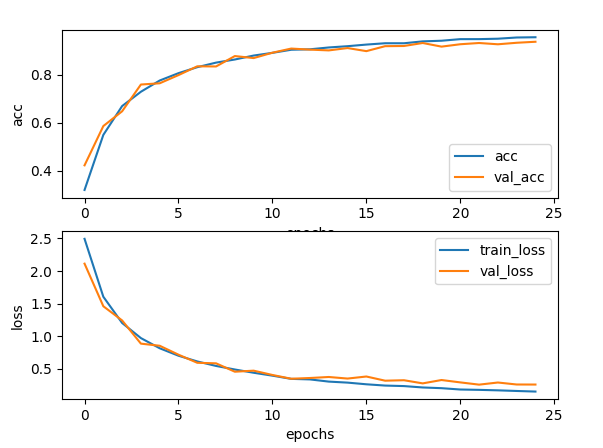 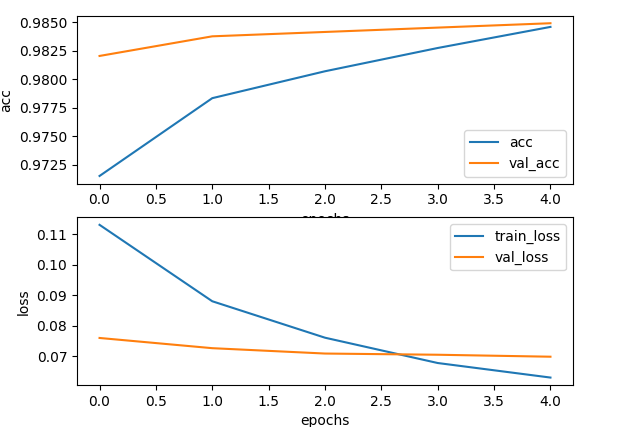

---
**Мысли автора**

Скрин слева - обучение с нуля. Там координальные методы борьбы с переобучением, что вносит много своих коррективов

Скрин справа - дообучение. Lr поменьше, аугментация не такая серьезная и тд.


---

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [37]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [38]:
label_encoder = pickle.load(open(SimpsonsDataset.LABEL_DIR, 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [40]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

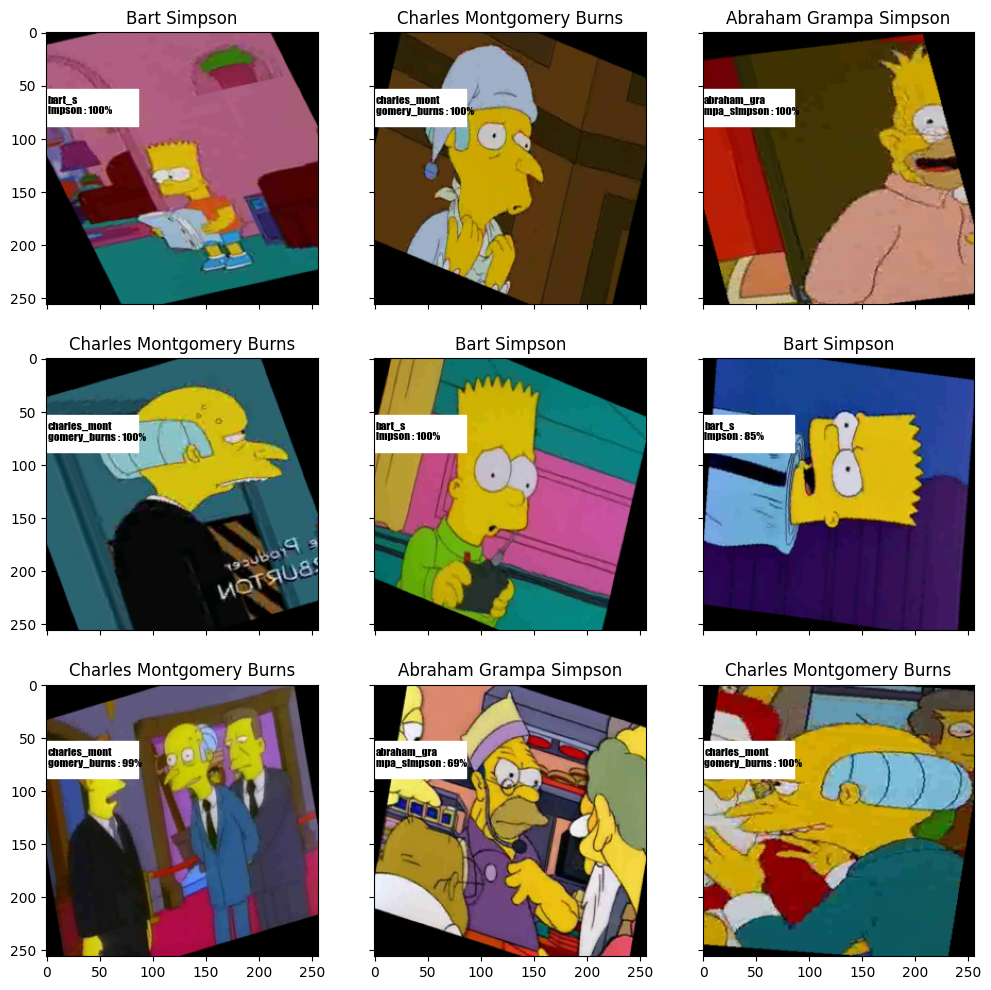

In [41]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(
    nrows=3, ncols=3, figsize=(12, 12),
    sharey=True, sharex=True,
)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    actual_text = f"Actual : {img_label}"

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

---
**Мысли автора**

Команда: LicrimoVor_65558024

---

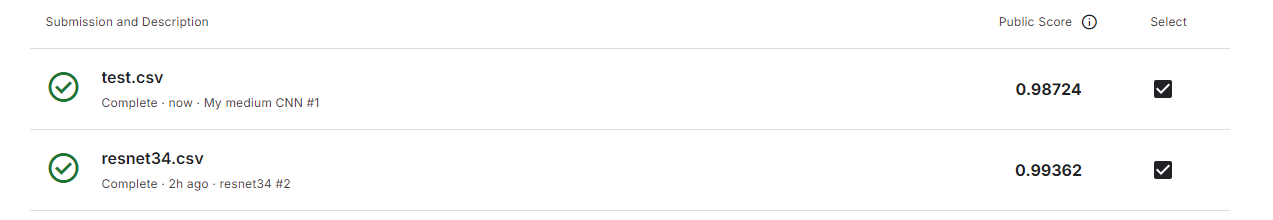